Librerias necesarias

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

Definimos nuestra clase para los nodos, se llamaran "city" porque en el problema del vendedor viajero son ciudades

In [2]:
class City:
    def __init__(self, x, y): #inicia mi nodo
        self.x = x
        self.y = y
    
    def distance(self, city):                  #distancia euclidada de mi nodo con otro nodo
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):                                        #retorna el nodo
        return "(" + str(self.x) + "," + str(self.y) + ")"
    def retx(self):
        return self.x
    def rety(self):
        return self.y

Luego necesitaremos una funcion que me calcule la distancia de un recorrido, para eso generaremos una clase que guarde esto. Por temas de bibliografia (y contexto del problema) la función se llamará fitness

In [3]:
class Fitness:
    def __init__(self, route):    #routa es una lista con city en el orden que seran visitadas
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):    #calculamos la distancia de la ruta
        if self.distance ==0:
            pathDistance = 0                    
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):    
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())    #queremos minimizar la distancia equivalente a maxmizar 1/fitness
        return self.fitness

# Creamos nuestra población inicial

Necesitamos crear una rutas aleatorias

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Primera población, es decir primera lista de rutas (que sera aleatoria)    

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

# Algoritmo genetico 

Resultados de la población

In [6]:
def rankRoutes(population):   #rankeamos nuestras rutas 
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Creamos una función de seleccion para crear la lista de rutas padres

Familia de soluciones: 
- Elite (1 o 2) 
- Cruce dos soluciones -> nueva 
- Mutación -> 1 solucion la cambia otra nueva 
Si tiene solucion optima, es dificil de hallar n!

In [7]:
def selection(popRanked, eliteSize):
    resultselecion = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        resultselecion.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                resultselecion.append(popRanked[i][0])
                break
    return resultselecion

Crear un pozo de funciones para el apareamiento

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Funcion para obtener un hijo de dos padres

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Funcion Breed pero para un pozo de varias funciones

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))   #reordenamos nuestro pool de forma aleatoria

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Mutacion de una ruta

In [11]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Aplicar mutaciones a una población

In [12]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
            if ind!=0:
                #agregar un if si la elite no se quiere que mute
                mutatedInd = mutate(population[ind], mutationRate)
            else:
                mutatedInd=population[ind]     #eleccion para mantener solucion optima
            mutatedPop.append(mutatedInd)
    return mutatedPop

Creamos nuestra nueva población, con la elite los hijos y las mutaciones


In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)  #escogemos a nuestra elite
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

AL final creamos el algoritmo genetico  (bastante simple teniendo todas las funciones anteriores)

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

# Solo falta hacer correr nuestro algoritmo genetico

In [15]:
cityList = []

for i in range(0,20):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [25]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1406.2150385543086
Final distance: 691.8326222431343


[(66,95),
 (52,62),
 (19,52),
 (23,37),
 (86,33),
 (125,57),
 (106,101),
 (116,104),
 (152,89),
 (181,99),
 (173,113),
 (152,155),
 (77,191),
 (61,156),
 (64,152),
 (42,136),
 (28,151),
 (7,150),
 (20,104),
 (32,81)]

# Y si ploteamos el fitnnes

In [18]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

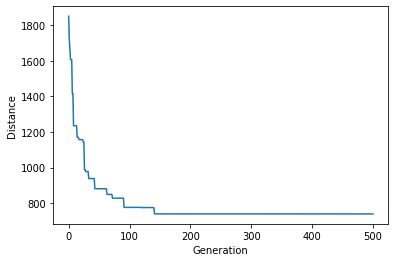

In [19]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [40]:
archivo="datos.txt"
x=[]
arch=open(archivo,"r")
while arch:
        linea=arch.readline()
        if linea =="":
            break
        x.append(int(float(linea.strip())))
arch.close()

# Y si ploteamos la ruta optima?

In [22]:
def plotTSP(paths, num_iters=1):


    x = []; y = []
    for i in paths[0]:
        x.append(i.retx())
        y.append(i.rety())

    plt.plot(x, y, 'co')

    #
    a_scale = float(max(x))/float(100)


    if num_iters > 1:

        for i in range(1, num_iters):

           
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(j.retx())
                yi.append(j.rety())

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

   
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()

In [48]:
cityList

[(39,140),
 (24,32),
 (197,39),
 (110,151),
 (20,196),
 (34,11),
 (103,48),
 (27,198),
 (117,141),
 (135,144),
 (190,117),
 (171,42),
 (199,189),
 (12,13),
 (144,50),
 (140,74),
 (186,3),
 (21,30),
 (13,54),
 (157,33),
 (38,102),
 (175,19),
 (54,60),
 (155,58),
 (187,194)]

In [55]:
v=[]
for i in range (0,100):
    v.append(createRoute(cityList))

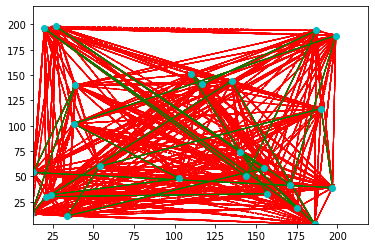

In [58]:
plotTSP(v,len(v)-1)

In [23]:
def geneticAlgorithmsuperPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    plotTSP([pop[rankRoutes(pop)[0][0]]],1)
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

In [ ]:
geneticAlgorithmsuperPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=200)